In [ ]:
import sys
sys.path.append('../')
sys.path.append('../../data/sdo')
from preprocess_aia import AIADivideExposureEditor, NormalizeEditor

def inverse(x):
    LoLim = 0
    UpLim = 14
    x = x * ((UpLim - LoLim)/2) + ((UpLim + LoLim)/2)  # data -> [LoLim, UpLim]
    x = 2**x - 1                                       # data -> [2**LoLim-1, 2**UpLim-1]
    return x

import yaml
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from networks import define_G
from pipeline import AlignedDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
with open("../configs/sdo/unet_patchgan.yaml") as file:
    cfg = yaml.safe_load(file)
    data = cfg['data']

G = define_G(cfg)

G.load_state_dict(
    torch.load("../results/sdo/default_lightning/logs/version_2/checkpoints/49_12050_G.pth", weights_only=True)
)

G = G.to(device)

initialize network with normal


In [ ]:
val_dataset = AlignedDataset(
    input_dir=data['val']['input_dir'], 
    target_dir=data['val']['target_dir'],
    image_size=data['image_size'],
    ext=data['ext']
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=data['val']['batch_size'], 
    shuffle=data['val']['shuffle'],
    num_workers=data['val']['num_workers'],
    pin_memory=data['val']['pin_memory'],
    drop_last=data['val']['drop_last']
)

test_dataset = AlignedDataset(
    input_dir=data['test']['input_dir'], 
    target_dir=data['test']['target_dir'],
    image_size=data['image_size'],
    ext=data['ext']
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=data['test']['batch_size'], 
    shuffle=data['test']['shuffle'],
    num_workers=data['test']['num_workers'],
    pin_memory=data['test']['pin_memory'],
    drop_last=data['test']['drop_last']
)

In [ ]:
inputs, real_target = next(iter(val_loader))
inputs = inputs.to(device)
fake_target = G(inputs)
inputs = inputs.detach().cpu()
fake_target = fake_target.detach().cpu()

inputs = inputs.squeeze(0)
real_target = real_target.squeeze(0)
fake_target = fake_target.squeeze(0)

print(inputs.shape)
print(real_target.shape)
print(fake_target.shape)

input171 = inputs[0]
input304 = inputs[1]
real193 = real_target[0]
fake193 = fake_target[0]

torch.Size([2, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


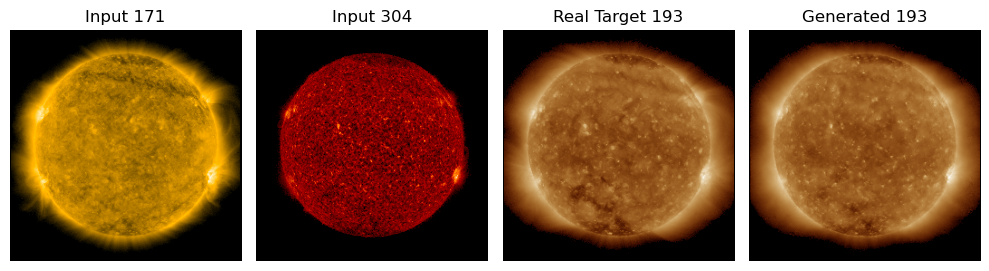

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(input171, cmap="sdoaia171", origin="lower", vmin=-0.5)
plt.axis("off")
plt.title("Input 171")
plt.subplot(1, 4, 2)
plt.imshow(input304, cmap="sdoaia304", origin="lower", vmin=-0.5)
plt.axis("off")
plt.title("Input 304")
plt.subplot(1, 4, 3)
plt.imshow(real193, cmap="sdoaia193", origin="lower", vmin=-0.5)
plt.axis("off")
plt.title("Real Target 193")
plt.subplot(1, 4, 4)
plt.imshow(fake193, cmap="sdoaia193", origin="lower", vmin=-0.5)
plt.axis("off")
plt.title("Generated 193")
plt.tight_layout()
plt.show()

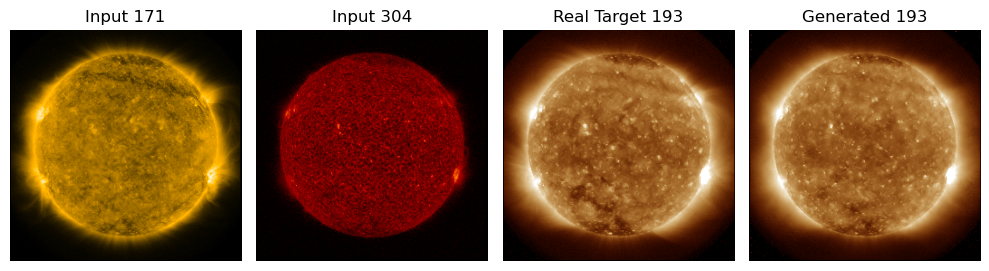

In [ ]:
from astropy.visualization import ImageNormalize, AsinhStretch

input171_inv = inverse(input171)
input304_inv = inverse(input304)
real193_inv = inverse(real193)
fake193_inv = inverse(fake193)

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(input171_inv, cmap="sdoaia171", origin="lower", norm=ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.02)))
plt.axis("off")
plt.title("Input 171")
plt.subplot(1, 4, 2)
plt.imshow(input304_inv, cmap="sdoaia304", origin="lower", norm=ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.01)))
plt.axis("off")
plt.title("Input 304")
plt.subplot(1, 4, 3)
plt.imshow(real193_inv, cmap="sdoaia193", origin="lower", norm=ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.02)))
plt.axis("off")
plt.title("Real Target 193")
plt.subplot(1, 4, 4)
plt.imshow(fake193_inv, cmap="sdoaia193", origin="lower", norm=ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.02)))
plt.axis("off")
plt.title("Generated 193")
plt.tight_layout()
plt.show()